In this file, we present the calculations analyzing the input data and analyzing the predictions of drug phenotype effects.

First we load in the files we made in notebook `1. curate_data.ipynb`

In [1]:
outfile='testdir/testfiles'
pfile='data_for_regression/multixcan_res_10027.txt'
dfile='data_for_regression/epa.txt'
yfile='data_for_regression/sider_y.txt'
usfile='data_for_regression/US.txt'
ufile='data_for_regression/U.txt'
test='test'
import sys
sys.path.append("code/")
import setup_data
P, Ymat, Yalign, US, U, UB, SB, VB, make_L = setup_data.setup(pfile, yfile, dfile, usfile, ufile, False)

usfile is  data_for_regression/US.txt


## Results "3.1 Data curation and initial assessment"
SEt up the pairwise comparisons

In [4]:
from sklearn.metrics import pairwise_distances
from scipy import stats
from my_util import upper_tri

### Statistical test of similarity of *diseases* in terms of drugs associated vs in terms of genetic regulation
Loading in processed `Ymat` (side effects) and PhenomXcan `P` (phenotype genetic regulation)

In [10]:

jacc_disease_drug_sim = pd.DataFrame(pairwise_distances(Ymat.transpose().values==1,metric='jaccard'),
                       index=Ymat.columns,columns=Ymat.columns)


pcors = P.loc[:,Ymat.columns].corr(method='spearman')


pcors = upper_tri(pcors) #ttc.loc[ptstack.index, ptstack.index])


stats.spearmanr(upper_tri(jacc_disease_drug_sim),pcors)

SpearmanrResult(correlation=-0.11039370900920706, pvalue=2.0696576031480833e-53)

### Figure 1A

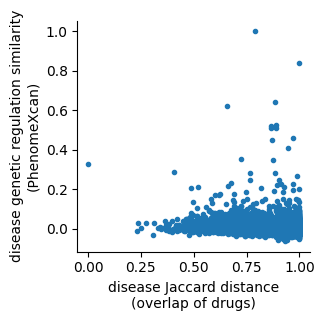

In [12]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,figsize=(3,3))
ax.plot(upper_tri(jacc_disease_drug_sim),pcors ,'.')
ax.set_xlabel("disease Jaccard distance\n(overlap of drugs)")
ax.set_ylabel("disease genetic regulation similarity\n(PhenomeXcan)")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.savefig("figs/disease_similarity_measures.png",bbox_inches='tight',dpi=300)

### Statistical test of similarity of *drugs* in terms of EPA endpoints vs phenotype side effects
Now:
- load in EPA
- get pairwise Spearman correlation of endpoints (dropping missing) = drug endpoint similarity
- get jaccard similarity of the drugs
- then compare these 2 measures of similarity

In [21]:


### load in EPA and make it into a matrix
epa = pd.read_table("intermediate_files/epa_compiled.txt.gz",sep="\t",index_col=0)
xstk = epa.loc[:,['cid','aenm','hit_pct']].set_index(['cid','aenm']).sort_index().transpose().stack('aenm')
#xstk = xstk.droplevel(0,0)
xstk.index = xstk.index.droplevel(0)
col = xstk.columns

def spea(x,y):
    sel = (x > -1) & (y>-1)
    return stats.spearmanr(x[sel], y[sel])[0]

spe = pd.DataFrame(pairwise_distances(xstk.transpose().fillna(-1) ,metric=spea),index=col,columns=col)

### load in side effects, again make it into a matrix
sider = pd.read_csv("input_data/meddra_all_se.tsv.gz",sep="\t",header=None)
sider['cid'] = sider[0].str.slice(4).map(int) ## get pubchem ID
sider_matched_filter = sider.loc[sider['cid'].isin(set(epa['cid'])) ,:] ## match to EPA pubchem ID
sider_matched_filter.columns = ['stitch_flat','stitch_stereo','UMLS_label', 'type','meddra','se_name','pubchem_cid']
pt = sider_matched_filter.loc[sider_matched_filter['type']=='PT',].drop_duplicates(['pubchem_cid','meddra']).copy()

pt['ae'] = 1
ptstack = pt.loc[:,['pubchem_cid','se_name','ae']].drop_duplicates(['pubchem_cid','se_name']).set_index(['pubchem_cid','se_name']).sort_index() #.unstack().shape
ptstack = ptstack.transpose().stack('se_name') ## make into matrix form
ptstack = ptstack.mask(pd.isnull(ptstack), other=0)
ptstack.index = ptstack.index.droplevel(0)
ptstack = ptstack.loc[ptstack.sum(axis=1) < 200,:] # removed anything very nonspecific

### 
drug_phesim = pd.DataFrame(pairwise_distances(pd.DataFrame(ptstack.transpose(),dtype=bool),metric='jaccard'),index=ptstack.columns,columns=ptstack.columns)
drug_phesim = upper_tri(drug_phesim.loc[spe.index, spe.index])
drug_epa_sim = upper_tri(spe)
x = drug_epa_sim.index.intersection(drug_phesim.index)
stats.spearmanr(drug_phesim.loc[x], drug_epa_sim.loc[x])


/share/pkg/python3/3.6_intel_pu3_2018.3.039/intelpython3/lib/python3.6/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


SpearmanrResult(correlation=-0.03373741128515219, pvalue=6.475781341553099e-24)

Linear regression analysis

In [59]:
def nna(x,y):
    return sum((x > -1) & (y > -1))
    #return stats.spearmanr(x[sel], y[sel])[0]
nnan = pd.DataFrame(pairwise_distances(xstk.transpose().fillna(-1),metric=nna),index=col,columns=col)
nnas = upper_tri(nnan.loc[spe.index, spe.index])
import statsmodels.api as sm
df = pd.DataFrame({'j':drug_phesim.loc[x],'num_nna':nnas.loc[x],'spe':drug_epa_sim.loc[x]})
df = sm.add_constant(df)
mod = sm.OLS(df['j'],df.drop('j',axis=1)).fit()
mod.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      j   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     118.7
Date:                Mon, 17 Apr 2023   Prob (F-statistic):           3.24e-52
Time:                        21:17:52   Log-Likelihood:             1.1524e+05
No. Observations:               89298   AIC:                        -2.305e+05
Df Residuals:                   89295   BIC:                        -2.304e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9291      0.001   1653.840      0.000       0.928       0.930
num_nna     1.568e-05   2.05e-06      7.661      0.000    1.17e-05    1.97e-05
spe           -0.0234      0.002    -13.835      0.000      -0.027      -0.020
==============================================================================
Omnibus:                    25096.727   Durbin-Watson:                   1.243
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            80776.347
Skew:                          -1.433   Prob(JB):                         0.00
Kurtosis:                       6.673   Cond. No.                     1.84e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.84e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [60]:
mod.pvalues

const      0.000000e+00
num_nna    1.861201e-14
spe        1.748472e-43
dtype: float64

## Results "3.2 Assessment of the model's predictive performance"

Here, we do analysis of the $W$ matrix and its predictions, from the results of `2. run_models.ipynb`.



### Figure 2A: Prediction distances
Load in the results of the held out drug analysis-- then compare to the nearest drug in terms of input distance (in $U_DS_D$).

Then just plot the values -- each point is one drug

In [3]:
### held out drug predictions 
leaveout = pd.read_csv('results/Ypred_leaveout_multix.txt',sep="\t",index_col=0)
leaveout = leaveout.loc[Ymat.index.map(int), Ymat.columns]
leaveout.index = Ymat.index

### nearest drug in drug EPA reduced space
corr = US.transpose().corr(method='spearman') - np.eye(US.shape[0])
max_ix = corr.idxmax(axis=1)
nn_pred = Ymat.loc[max_ix,:]
nn_pred.index = Ymat.index

### get Jaccard distance (higher = further) from true data Ymat to these 2 types of predictions
from scipy.spatial import distance
jaccard_dist_nn = pd.concat((nn_pred, Ymat),axis=1).apply(lambda x: distance.jaccard(x[:nn_pred.shape[1]], 
                                                                                       x[nn_pred.shape[1]:]),axis=1)

jaccard_dist_lo = pd.concat((leaveout, Ymat),axis=1).apply(lambda x: distance.jaccard(x[:nn_pred.shape[1]], 
                                                                                       x[nn_pred.shape[1]:]),axis=1)

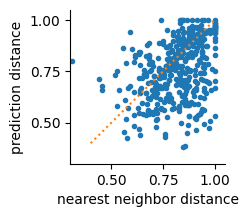

In [6]:
import matplotlib.pyplot as plt

f,ax = plt.subplots(1,figsize=(2,2))
ax.plot(jaccard_dist_nn,jaccard_dist_lo ,'.')
ax.plot([.4,1],[.4,1],':')
ax.set_xlim(.3,1.05)
ax.set_ylim(.3,1.05)
ax.set_xticks([.5,.75,1])
ax.set_yticks([.5,.75,1])
ax.set_xlabel("nearest neighbor distance")
ax.set_ylabel("prediction distance")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
f.savefig("nearest_neighbor_hold_outpredictions.pdf",bbox_inches='tight')

In [5]:
stats.ranksums(jaccard_dist_nn,jaccard_dist_lo )

RanksumsResult(statistic=5.535870513935947, pvalue=3.096863053871949e-08)

### Predictions discussed in this section
Obtain predictions: model was fit as $V_P \otimes U_DS_D \dot W_{DP} = Y $ so multiplying these together gives predictions (without intercept)
- $ U_DS_D$ reduced drug endpoint space
- $ U_DS_DW_{DP}$ mapping drug endpoints to projected effects on reduced phenome space
- $ U_DS_DW_{DP}V_P$ full predictions

In [4]:
names = pd.read_table("input_data/pubchem_names",header=None)
names[0] = names[0].map(str)
id2name = names.set_index(0).transpose().loc[1,:].to_dict()
name2id = names.set_index(1).transpose().loc[0,:].to_dict()

result_files = 'results/indications'
W = pd.read_table(result_files+ "_W.txt",index_col=0)
U_DS_DdotW = US.iloc[:,:W.shape[0]].dot(W).rename(id2name)

mod_red = pickle.load(open(result_files + '_lr.pkl','rb'))
VP = pd.read_table(result_files + '_VB.txt',index_col=0)

### predictions = $ U_DS_DW_{DP}V_P$ + intercepts
pred_red = U_DS_DdotW @ VP.transpose() + mod_red.intercept_[0]

pred_read.to_csv("results/indication_predictions.txt",sep="\t")

ModuleNotFoundError: No module named 'sklearn.linear_model.logistic'

In [7]:
sklearn.__version__

'1.0.2'

In [18]:
Ymat_indications = pd.read_csv("data_for_regression/all_disease_indication_151x413.txt",sep="\t",index_col=0).rename(columns=id2name)
Ymat_indications.head()

,gamma-Aminobutyric acid,Benzyl Alcohol,Betaine,Citric Acid,Salicylic Acid,Aminocaproic acid,Lactic Acid,Dimethyl Sulfoxide,Dopamine,Ethanolamine,...,Ethionamide,Prucalopride,Dasatinib,Vandetanib,Tolcapone,Acipimox,"5-chloro-N-({2-oxo-3-[4-(3-oxomorpholin-4-yl)phenyl]-1,3-oxazolidin-5-yl}methyl)thiophene-2-carboxamide",Everolimus,Pazopanib,Carfilzomib
se_name,,,,,,,,,,,,,,,,,,,,,
#Arthrosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AV-block,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Actinic keratosis,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Anxiety disorders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Breast Cancer,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
pred_red_match = pred_red.loc[set(Ymat_indications.columns) & set(pred_red.index),:]

Ymat_indications = Ymat_indications.loc[pred_red_match.columns,set(Ymat_indications.columns) & set(pred_red_match.index)].transpose()


pred_red_match.loc[Ymat_indications['Eczema']==0,'Eczema'].sort_values()

Disulfiram           -76.384160
Clotrimazole         -72.838426
Loratadine           -59.554425
Raloxifene           -58.712214
Carfilzomib          -58.065162
                        ...    
Sotalol                0.144657
Nepafenac              0.182960
Vecuronium bromide     0.338733
Metipranolol           1.162165
Fludrocortisone        1.602817
Name: Eczema, Length: 405, dtype: float64

In [79]:
glaucoma = 'Non-cancer illness code, self-reported: glaucoma'
pred_red_match.loc[Ymat_indications[glaucoma]==0,glaucoma].sort_values()

Troglitazone       -34.852543
Nitazoxanide       -28.334991
Nisoldipine        -28.319596
Mitotane           -26.543275
Clotrimazole       -26.293179
                      ...    
Felbamate            0.746012
Metyrapone           0.999977
Isoproterenol        1.373527
Chlorthalidone       1.533764
Methyclothiazide     2.193702
Name: Non-cancer illness code, self-reported: glaucoma, Length: 401, dtype: float64